# Tuning Models

## Import Packages

Let us import dffml and other packages that we might need.

In [1]:
from dffml import *
import contextlib
import logging
import sys
import asyncio
import nest_asyncio

To use asyncio in a notebook, we need to use nest_asycio.apply()

In [2]:
nest_asyncio.apply()

## Build our Dataset

util.Dffml has a very convinient function [cached_download()](../../api/util/net.rst#dffml.util.net.cached_download) that can be used to download datasets and make sure you don't download them if you have already.


The cached_download() has the following parameters:



1. `url` (str) – The URL to download

2. `target_path` (str, pathlib.Path) – Path on disk to store download

3. `expected_hash` (str) – SHA384 hash of the contents

4. `protocol_allowlist` (list, optional) – List of strings, one of which the URL must start with. 
   We won't be using this in our case.
          
Don't forget to calculate the `expected_hash`, you can find out how at [cached_download()](../../api/util/net.rst#dffml.util.net.cached_download)!

In [3]:
data_path = await cached_download(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    "wine_quality.csv",
    "789e98688f9ff18d4bae35afb71b006116ec9c529c1b21563fdaf5e785aea8b3937a55a4919c91ca2b0acb671300072c",
)

In Dffml, we try to use asynchronicity where we can, to get that extra bit of performance. Let's use the async version of load() to load the dataset that we just downloaded into a source. We can easily achieve this by declaring a [CSVSource](../../api/source/csv.rst) with the `data_path` and the `delimiter` value since the data we downloaded seems to have a non-comma delimiter.

After that, we can just create an array of records by loading each one through the load() function.

Feel free to also try out the no async version of load().

In [4]:
async def load_dataset(data_path):
    data_source = CSVSource(filename=data_path, delimiter=";")
    data = [record async for record in load(data_source)]
    return data


data = asyncio.run(load_dataset(data_path))

Dffml lets you visualize a record in quite a neat fashion. Lets have a look.

In [5]:
print(data[0], "\n")
print(len(data))


	Key:	0
                           Record Features
+----------------------------------------------------------------------+
|  fixed acidity  |                        7.4                         |
+----------------------------------------------------------------------+
| volatile acidity|                        0.7                         |
+----------------------------------------------------------------------+
|   citric acid   |                         0                          |
+----------------------------------------------------------------------+
|  residual sugar |                        1.9                         |
+----------------------------------------------------------------------+
|    chlorides    |                       0.076                        |
+----------------------------------------------------------------------+
|free sulfur dioxi|                         11                         |
+----------------------------------------------------------------------+

Lets split our dataset into train and test splits.

In [6]:
train_data = data[320:]
test_data = data[:320]
print(len(data), len(train_data), len(test_data))

1599 1279 320


In [7]:
!rm -rf "scikitsvc"

## Instantiate our Models with parameters

Dffml makes it quite easy to load models dynamically using the `Model.load()` function. All the entrypoints for models available in DFFML can be found at the [Model Plugins Page](../../plugins/dffml_model.rst). After that, you just have to parameterize the loaded models and they are ready to train!

In [8]:
XGBCModel = Model.load("xgbclassifier")

features = Features(
    Feature("fixed acidity", int, 1),
    Feature("volatile acidity", int, 1),
    Feature("citric acid", int, 1),
    Feature("residual sugar", int, 1),
    Feature("chlorides", int, 1),
    Feature("free sulfur dioxide", int, 1),
    Feature("total sulfur dioxide", int, 1),
    Feature("density", int, 1),
    Feature("pH", int, 1),
    Feature("sulphates", int, 1),
    Feature("alcohol", int, 1),
)

predict_feature = Feature("quality", int, 1)
model = XGBCModel(
    features=features,
    predict= predict_feature,
    location="xgbc",
)


## Train our Models
Finally, our models are ready to be trained using the `high-level` API. Let's make sure to pass each record as a parameter by simply using the unpacking operator(*).

In [9]:
await train(model, *train_data)

## Test our Models

To test our model, we'll use the `score()` function in the `high-level` API.

We ask for the accuracy to be assessed using the classification accuracy by passing "acscore" to `AccuracyScorer.load()`. You can find all the scorer entrypoints at the [Scorers page](../../plugins/dffml_accuracy.rst).

In [10]:
AccScore = AccuracyScorer.load("acscore")
scorer = AccScore()
accuracy1 = await score(model, scorer, predict_feature, *test_data)
print("Accuracy:", accuracy1)

Accuracy: 0.575


## Tuning Models


Let's try to tune out models by mutating the hyperparameters in the config of the model. You can find a list of mutable parameters in docs.

In [11]:
with model.config.no_enforce_immutable():
    model.config.learning_rate = 0.2
    model.config.n_estimators = 200
    model.config.max_depth = 3
await train(model, *train_data)
accuracy1 = await score(model, scorer, predict_feature, *test_data)
print("Accuracy:", accuracy1)

Accuracy: 0.55


**Parameter Grid**

Tuning models can be demanding if done manually.
Let us define a Parameter Grid and call the `optimize()` function through the context to tune the Hyperparameters.

Before that, let's set output to logging info so we know whats happening in the parameter grid.

In [12]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [13]:
from dffml.accuracy import MeanSquaredErrorAccuracy
from dffml.tuner import ParameterGrid

parameter_optim = ParameterGrid(
    parameters = {
        "learning_rate" : [0.2, 0.3, 0.4, 0.5],
        "n_estimators" : [50, 100, 150, 200],
        "max_depth" : [3, 4, 5, 6, 8],
    }
)
async with contextlib.AsyncExitStack() as astack:
    tuner = await astack.enter_async_context(parameter_optim)
    octx = await astack.enter_async_context(tuner())

tuned_accuracy1 = await octx.optimize(model, predict_feature, scorer, train_data, test_data)
print("Tuned Accuracy:", tuned_accuracy1)

INFO:root:Optimizing model with parameter grid: {'learning_rate': [0.2, 0.3, 0.4, 0.5], 'n_estimators': [50, 100, 150, 200], 'max_depth': [3, 4, 5, 6, 8]}
INFO:root:['learning_rate', 'n_estimators', 'max_depth']
INFO:root:(0.2, 50, 3)
INFO:root:Accuracy of the tuned model: 0.565625
INFO:root:(0.2, 50, 4)
INFO:root:Accuracy of the tuned model: 0.571875
INFO:root:(0.2, 50, 5)
INFO:root:Accuracy of the tuned model: 0.5875
INFO:root:(0.2, 50, 6)
INFO:root:Accuracy of the tuned model: 0.575
INFO:root:(0.2, 50, 8)
INFO:root:Accuracy of the tuned model: 0.571875
INFO:root:(0.2, 100, 3)
INFO:root:Accuracy of the tuned model: 0.54375
INFO:root:(0.2, 100, 4)
INFO:root:Accuracy of the tuned model: 0.575
INFO:root:(0.2, 100, 5)
INFO:root:Accuracy of the tuned model: 0.596875
INFO:root:(0.2, 100, 6)
INFO:root:Accuracy of the tuned model: 0.575
INFO:root:(0.2, 100, 8)
INFO:root:Accuracy of the tuned model: 0.565625
INFO:root:(0.2, 150, 3)
INFO:root:Accuracy of the tuned model: 0.540625
INFO:root:(0.

**Visualize the Accuracies**

<BarContainer object of 2 artists>

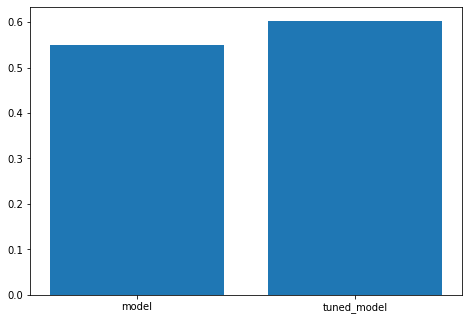

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["model", "tuned_model"], [accuracy1,tuned_accuracy1])